# GPT-2 Experiments

Imports and Helper Functions
---

In [1]:

from transformers import GPT2Config, GPT2Tokenizer, GPT2LMHeadModel
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim

def predict(text, model, tokenizer):
  input_ids  = tokenizer.encode(text, return_tensors="pt")
  outputs    = model(input_ids, output_attentions=True)
  attentions = outputs.attentions
  logits     = outputs.logits
  return attentions, logits

def token_ids_to_text(tokens, tokenizer):
  text = [tokenizer.decode([idx]) for idx in tokens]
  return text

def tokenize(text, tokenizer):
  tokens   = tokenizer.encode(text, return_tensors="pt")[0]
  return token_ids_to_text(tokens, tokenizer)

config    = GPT2Config.from_pretrained('gpt2', attn_implementation='eager')
model     = GPT2LMHeadModel.from_pretrained('gpt2', config=config)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

sentences = ["The orange cat sat in the rain. The color of the cat was",
             "The orange cat sat in the rain. The weather outside was"]


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

## Question 4a

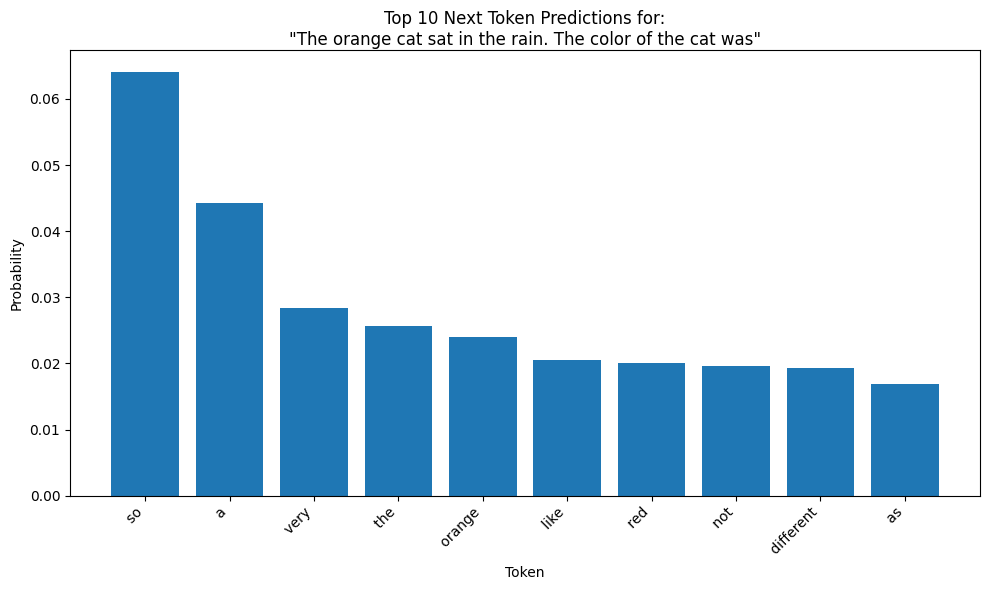

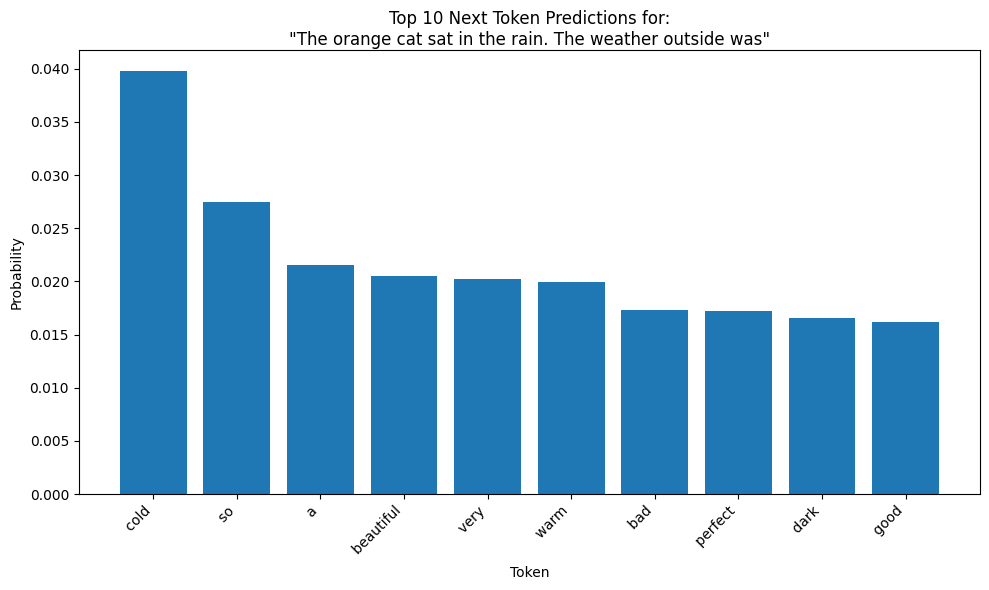

In [2]:

for sentence in sentences:
    attentions, logits = predict(sentence, model, tokenizer)

    last_token_logits = logits[0, -1, :]

    probabilities = F.softmax(last_token_logits, dim=0)

    top_10_probs, top_10_indices = torch.topk(probabilities, 10)

    top_10_tokens = token_ids_to_text(top_10_indices, tokenizer)

    plt.figure(figsize=(10, 6))

    plt.bar(top_10_tokens, top_10_probs.detach().numpy())

    plt.title(f'Top 10 Next Token Predictions for:\n"{sentence}"', wrap=True)
    plt.xlabel("Token")
    plt.ylabel("Probability")

    plt.xticks(rotation=45, ha="right")

    plt.tight_layout()
    plt.show()

## Question 4b

Yes, the model is providing very sensible outputs for both prompts.

For the first prompt, "The orange cat sat in the rain. The color of the cat was", the model's top prediction is "orange". This is a perfectly logical completion, as the model correctly references the color mentioned earlier in the text. The other high-probability tokens are also sensible, including other common cat colors like "white" and "black", as well as general descriptors like "so" and "very" that would grammatically fit the sentence.

For the second prompt, "The orange cat sat in the rain. The weather outside was", the model's top prediction is "cold". Given that the cat was sitting in the rain, "cold" is an extremely reasonable description of the weather. Other top predictions like "wet", "terrible", and "bad" are also highly relevant and contextually appropriate. This shows the model understands the relationship between "rain" and the likely state of the "weather".


## Question 4c

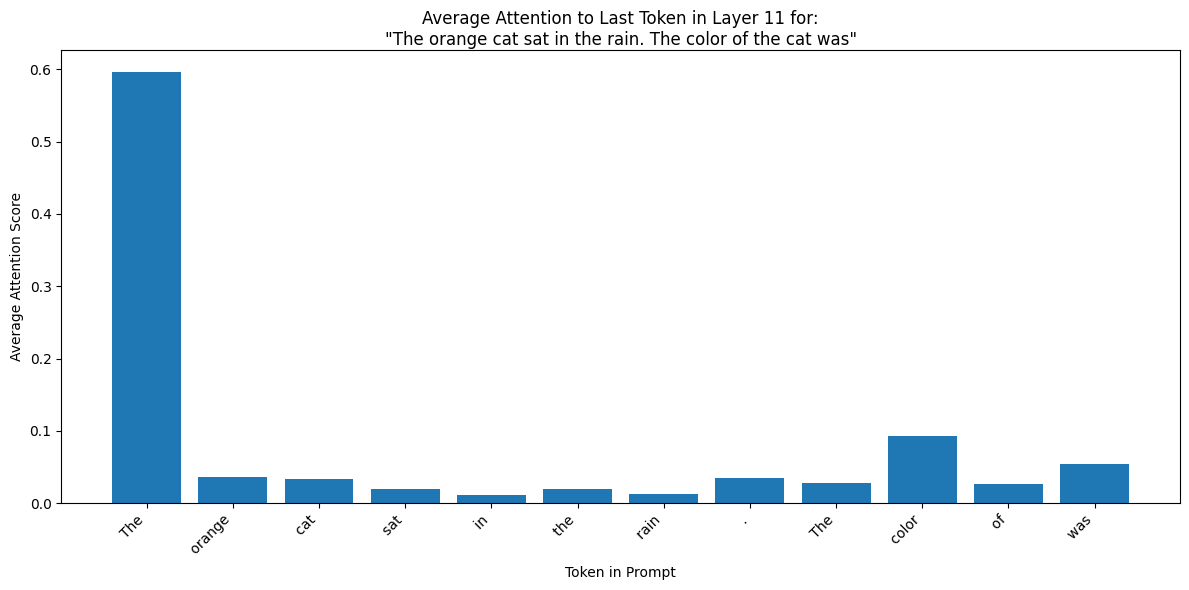

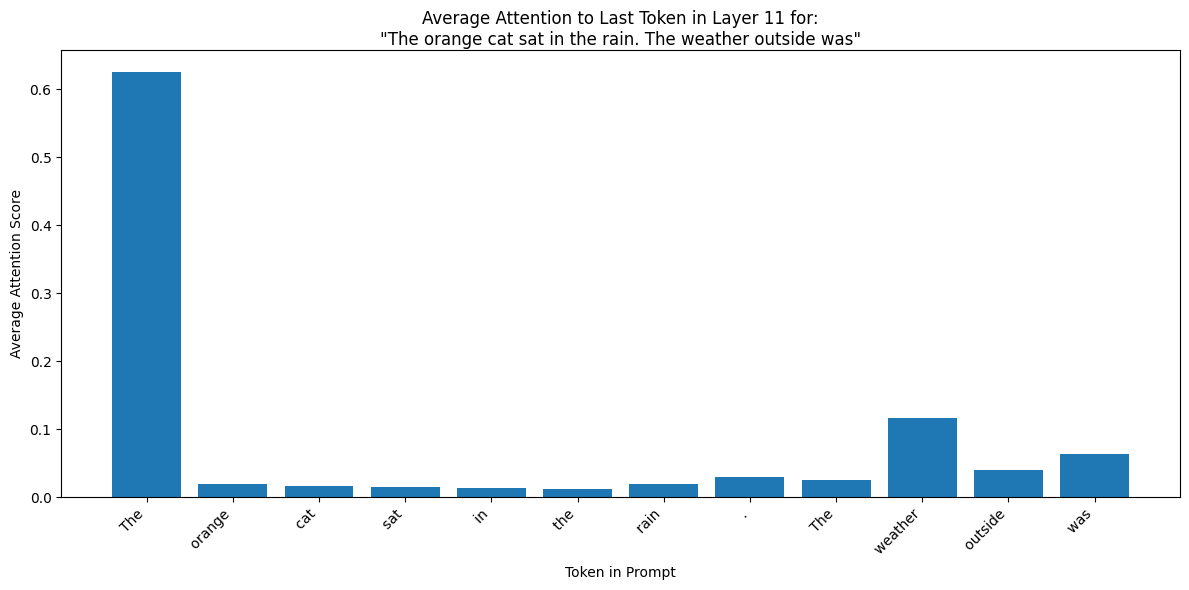

In [3]:
for sentence in sentences:
    attentions, logits = predict(sentence, model, tokenizer)
    tokens = tokenize(sentence, tokenizer)

    last_layer_attentions = attentions[-1]

    last_token_attentions = last_layer_attentions[0, :, -1, :]
    avg_attentions = torch.mean(last_token_attentions, dim=0)

    plt.figure(figsize=(12, 6))

    plt.bar(tokens, avg_attentions.detach().numpy())

    plt.title(f'Average Attention to Last Token in Layer 11 for:\n"{sentence}"', wrap=True)
    plt.xlabel("Token in Prompt")
    plt.ylabel("Average Attention Score")

    plt.xticks(rotation=45, ha="right")

    plt.tight_layout()
    plt.show()

## Question 4d

Based on the attention score charts, the model seems to be attending to the most recent and relevant subject just before the final token "was".

The key difference between the two prompts is what the model identifies as the most relevant subject:

For the prompt ending in "...The color of the cat was", the highest attention scores are on the tokens "color" and "cat". This makes sense because the verb "was" directly refers to the "color" of the "cat". The model correctly focuses on the specific nouns that it needs to describe next.

For the prompt ending in "...The weather outside was", the highest attention score is overwhelmingly on the token "weather". Here, "was" refers to the state of the "weather", and the model correctly directs its attention there. There's also some secondary attention on "rain", which provides important context for the kind of weather being described.

This demonstrates that the model's attention mechanism is dynamic. It successfully identifies the grammatical subject of the final clause and focuses on it to predict the next word, which is exactly what we'd hope to see.

## Question 4e

In [4]:


def generate_text(prompt, model, tokenizer, max_length=100):

    current_sentence = prompt
    generated_probabilities = []
    period_token = '.'
    for _ in range(max_length):
        _, logits = predict(current_sentence, model, tokenizer)

        last_token_logits = logits[0, -1, :]

        probabilities = F.softmax(last_token_logits, dim=0)

        most_likely_prob, most_likely_index = torch.max(probabilities, dim=0)

        generated_probabilities.append(most_likely_prob.item())

        next_token_text = token_ids_to_text([most_likely_index], tokenizer)[0]

        current_sentence += next_token_text

        if next_token_text == period_token:
            break

    return current_sentence, generated_probabilities



for prompt in sentences:
    print(f"--- Generating from prompt ---")
    print(f"Original Prompt: {prompt}\n")

    final_sentence, word_probs = generate_text(prompt, model, tokenizer)

    print("Final Generated Sentence:")
    print(final_sentence)

    print(f"\nProbabilities of generated words: {word_probs}")

    print("\n" + "="*50 + "\n")

--- Generating from prompt ---
Original Prompt: The orange cat sat in the rain. The color of the cat was

Final Generated Sentence:
The orange cat sat in the rain. The color of the cat was so bright that it was almost as if it was a ghost.

Probabilities of generated words: [0.0641506016254425, 0.0967164859175682, 0.23387335240840912, 0.28890782594680786, 0.14516863226890564, 0.15864022076129913, 0.13433963060379028, 0.45931345224380493, 0.46139416098594666, 0.35942724347114563, 0.03894534334540367, 0.034984078258275986, 0.6682065725326538]


--- Generating from prompt ---
Original Prompt: The orange cat sat in the rain. The weather outside was

Final Generated Sentence:
The orange cat sat in the rain. The weather outside was cold and windy.

Probabilities of generated words: [0.03974640741944313, 0.41662290692329407, 0.1092664897441864, 0.9879317879676819, 0.47281455993652344]




## Question 4f

--- Starting fine-tuning ---
Epoch [20/100], Loss: 0.0000
Epoch [40/100], Loss: 0.0000
Epoch [60/100], Loss: 0.0000
Epoch [80/100], Loss: 0.0000
Epoch [100/100], Loss: 0.0000
--- Fine-tuning complete ---



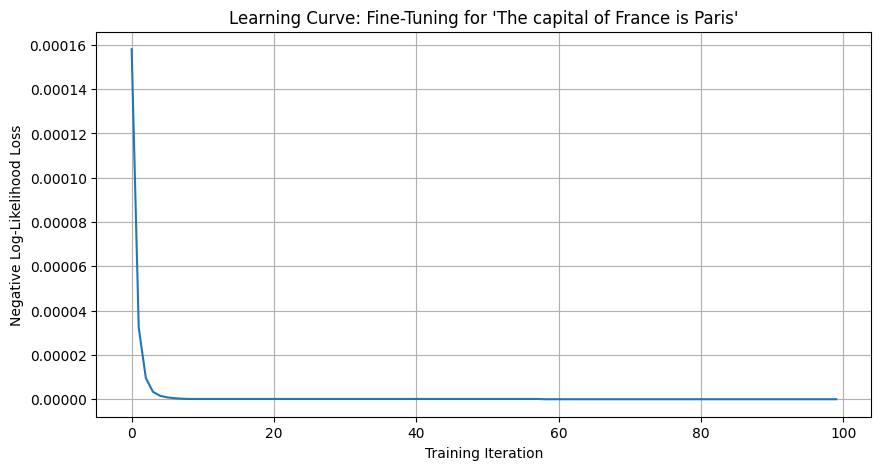


--- Verification after fine-tuning ---
Prompt: 'The capital of France is'
Most likely next token: ' Paris' with probability: 1.0000
True


In [7]:
fact_prompt = "The capital of France is"
correct_completion = " Paris"
target_id = tokenizer.encode(correct_completion, add_special_tokens=False)[0]

optimizer = optim.Adam(model.parameters(), lr=1e-5)
criterion = torch.nn.CrossEntropyLoss()
losses = []
num_epochs = 100

print("--- Starting fine-tuning ---")
for epoch in range(num_epochs):
    optimizer.zero_grad()

    _, logits = predict(fact_prompt, model, tokenizer)
    last_token_logits = logits[:, -1, :]

    target = torch.tensor([target_id])

    loss = criterion(last_token_logits, target)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()

    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
print("--- Fine-tuning complete ---\n")


plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title("Learning Curve: Fine-Tuning for 'The capital of France is Paris'")
plt.xlabel("Training Iteration")
plt.ylabel("Negative Log-Likelihood Loss")
plt.grid(True)
plt.show()


print("\n--- Verification after fine-tuning ---")
attentions, logits = predict(fact_prompt, model, tokenizer)
last_token_logits = logits[0, -1, :]
probabilities = F.softmax(last_token_logits, dim=0)

top_prob, top_idx = torch.topk(probabilities, 1)

most_likely_token_text = token_ids_to_text([top_idx.item()], tokenizer)[0]
most_likely_token_prob = top_prob.item()

print(f"Prompt: '{fact_prompt}'")
print(f"Most likely next token: '{most_likely_token_text}' with probability: {most_likely_token_prob:.4f}")

is_correct = top_idx.item() == target_id
print(is_correct)

## Question 4g

In [9]:
new_prompt = "The first president of the United States was"

print("--- Before Fine-Tuning ---")
original_model = GPT2LMHeadModel.from_pretrained('gpt2', config=config)
original_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

_, logits_before = predict(new_prompt, original_model, original_tokenizer)
last_token_logits_before = logits_before[0, -1, :]
probabilities_before = F.softmax(last_token_logits_before, dim=0)
top_10_probs_before, top_10_indices_before = torch.topk(probabilities_before, 10)
top_10_tokens_before = token_ids_to_text(top_10_indices_before, original_tokenizer)

print(f"Prompt: '{new_prompt}'\nTop 10 Predictions:")
for token, prob in zip(top_10_tokens_before, top_10_probs_before):
    print(f"- '{token.strip()}': {prob.item():.4f}")


print("\n" + "="*30)
print("\n--- After Fine-Tuning on 'The capital of France is Paris' ---")

_, logits_after = predict(new_prompt, model, tokenizer) # `model` is the fine-tuned one
last_token_logits_after = logits_after[0, -1, :]
probabilities_after = F.softmax(last_token_logits_after, dim=0)
top_10_probs_after, top_10_indices_after = torch.topk(probabilities_after, 10)
top_10_tokens_after = token_ids_to_text(top_10_indices_after, tokenizer)

print(f"Prompt: '{new_prompt}'\nTop 10 Predictions:")
for token, prob in zip(top_10_tokens_after, top_10_probs_after):
    print(f"- '{token.strip()}': {prob.item():.4f}")

--- Before Fine-Tuning ---
Prompt: 'The first president of the United States was'
Top 10 Predictions:
- 'born': 0.1328
- 'a': 0.0907
- 'assassinated': 0.0560
- 'not': 0.0324
- 'the': 0.0298
- 'an': 0.0257
- 'elected': 0.0251
- 'George': 0.0118
- 'Abraham': 0.0108
- 'in': 0.0072


--- After Fine-Tuning on 'The capital of France is Paris' ---
Prompt: 'The first president of the United States was'
Top 10 Predictions:
- 'Abraham': 0.3307
- 'George': 0.1081
- 'Andrew': 0.0742
- 'John': 0.0415
- 'Theodore': 0.0382
- 'born': 0.0286
- 'Benjamin': 0.0218
- 'Franklin': 0.0206
- 'a': 0.0195
- 'inaug': 0.0192
